In [ ]:
!pip install pyramid-arima

In [362]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

# imports and settings for plots
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr 
import seaborn as sns

from pyramid.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [3]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(18,9)})

#### Задача:
1. Воспроизведите график числа рекламных событий по дням. 
2. Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло. 
3. Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики. 
Иными словами, предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день. 
Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике? 

Предложите вариант кода, который решает эту задачу. Реализовывать логику нотификации не нужно, только поиск аномального дня, часа, пятиминутки в данных рекламной статистики. 

Немного дополнительной информации о структуре рекламы ВКонтакте. 
Есть две основные группы рекламодателей: агентства и клиенты. 
Агентствами являются рекламные кабинеты юридических лиц. Среди клиентов же существуют как клиенты этих самых агентств, так и автономные рекламные кабинеты физических лиц, над которыми нет агентств. 
Рекламные кампании — это наборы рекламных объявлений. 
Они есть в каждом кабинете. 

Описание данных:

- time — время взаимодействия пользователя с рекламой в формате UnixTime;
- event — тип взаимодействия (click — клик на объявление, view — показ объявления, report — жалоба на объявление);
- ad_cost_type — тип трат рекламного объявления (CPM — траты за 1000 показов, CPC — траты за клик);
- has_video — наличие видео в объявлении (0 — нет, 1 — есть);
- agency_union_id — id рекламного агентства (если рекламный кабинет принадлежит физическому лицу, то ячейка будет заполнена значением 'no_agency');
- client_union_id — id рекламного клиента;
- campaign_union_id — id рекламной кампании;
- ad_id — id рекламного объявления;
- platform — платформа, с которой пользователь взаимодействовал с рекламой (web — веб-версия, mvk — мобильная версия, iphone — IOS-приложение, android — Android-приложение, wphone — Windows Phone-приложение).

#### Read data

Считаем первые n-строк, чтобы не загружать весь датасет в память целиком, посмотрим на данные и выберем нужные параметры для считывания.

In [4]:
path = 'data/vk_test_data.csv'
df = pd.read_csv(path, 
                 nrows = 5)

In [5]:
df

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
0,1.554744e+09,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08
1,1.555103e+09,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12
2,1.555403e+09,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16
3,1.554822e+09,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09
4,1.554967e+09,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11


Сразу определим типы для переменных время и наличие видео.

In [6]:
df = pd.read_csv(path, 
                 sep=",",
                 dtype={'time': 'uint32',
                        'has_video': 'bool'})

df['time_from_timestamp'] = pd.to_datetime(df.time,unit='s')

In [7]:
'''
# auxillary method, to check if value is in range
vals = [1554744145, np.int32(2), np.int64(1), np.float64(0)]
[(e, type(e), isinstance(e, (int, np.integer))) for e in vals]
''';

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122097 entries, 0 to 122096
Data columns (total 11 columns):
time                   122097 non-null uint32
event                  122097 non-null object
ad_cost_type           122097 non-null object
has_video              122097 non-null bool
agency_union_id        122097 non-null object
client_union_id        122097 non-null object
campaign_union_id      122097 non-null object
ad_id                  122097 non-null object
platform               122097 non-null object
date                   122097 non-null object
time_from_timestamp    122097 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), object(8), uint32(1)
memory usage: 9.0+ MB


In [9]:
df.head(10)

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
0,1554744145,report,CPM,False,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08,2019-04-08 17:22:25
1,1555103458,click,CPM,False,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12,2019-04-12 21:10:58
2,1555402601,click,CPM,False,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16,2019-04-16 08:16:41
3,1554822479,click,CPM,False,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
4,1554966717,click,CPM,False,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11,2019-04-11 07:11:57
5,1555418913,view,CPC,False,no_agency,client_265,campaign_13516,ad_13517,android,2019-04-16,2019-04-16 12:48:33
6,1555146351,report,CPM,False,no_agency,client_22021,campaign_34637,ad_34651,mvk,2019-04-13,2019-04-13 09:05:51
7,1554503043,view,CPM,False,agency_155,client_105617,campaign_106015,ad_106015,iphone,2019-04-05,2019-04-05 22:24:03
8,1554940634,view,CPM,False,no_agency,client_264,campaign_13491,ad_13513,android,2019-04-10,2019-04-10 23:57:14
9,1554719466,view,CPM,False,no_agency,client_1728,campaign_19254,ad_19255,android,2019-04-08,2019-04-08 10:31:06


#### Lineplot

Повторим график из задания, для этого сгруппируем записи по дням и посчитаем количество событий.

In [10]:
count_adv_by_day = df.groupby('date', as_index=False).\
agg({'event':'count'})\
.rename(columns = {'event':'event_count'})\


# need it for correct usage of date formatter in plot
count_adv_by_day['date'] = pd.to_datetime(count_adv_by_day.date, format='%Y-%m-%d')

count_adv_by_day.sort_values(by = 'date', ascending=True, inplace=True)

In [11]:
count_adv_by_day

,date,event_count
0,2019-04-01,5172
1,2019-04-02,5269
2,2019-04-03,5357
3,2019-04-04,5108
4,2019-04-05,5305
5,2019-04-06,3955
6,2019-04-07,4091
7,2019-04-08,8902
8,2019-04-09,7963
9,2019-04-10,7098


In [12]:
# custom formatter for y-axis on plot
def y_fmt(tick_val, pos):
    if tick_val > 1000000:
        val = int(tick_val)/1000000
        return (str(val) + "M")
    elif tick_val > 1000:
        val = int(int(tick_val) / 1000)
        return (str(val) + "k")
    else:
        return tick_val

C:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


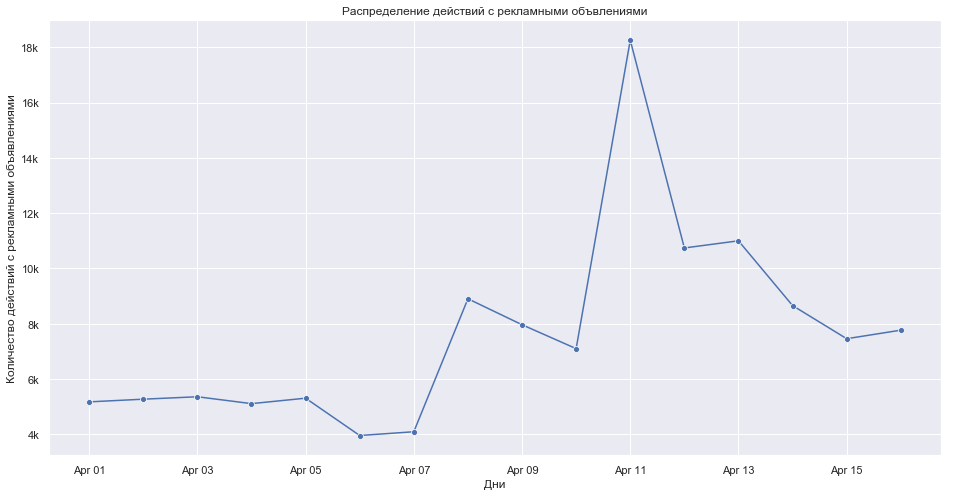

In [13]:
ax = sns.lineplot(x = 'date', 
                  y = 'event_count', 
                  marker="o",
                  data = count_adv_by_day)

ax.figure.set_size_inches(16, 8)
ax.set_title('Распределение действий с рекламными объвлениями')
ax.set_xlabel('Дни')
ax.set_ylabel('Количество действий с рекламными объявлениями')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

yfmt = tkr.FuncFormatter(y_fmt); 
ax.yaxis.set_major_formatter(yfmt);

На графике явно виден рост количества событий, который начинается 10 апреля и заканчивается 12 апрелем.

#### Splash reasons?

Причин такого всплеска может быть несколько, в первую очередь это может быть какой-либо технический сбой, затем это может быть какая-либо рекламная акция или же какое-либо произошедшее массовое событие.

Попробуем сначала посмотреть на пропуски и наличие дупликатов, а затем проанализировать каких платформ это коснулось больше всего.

In [14]:
# check for NAs for safety
df.isna().sum()

time                   0
event                  0
ad_cost_type           0
has_video              0
agency_union_id        0
client_union_id        0
campaign_union_id      0
ad_id                  0
platform               0
date                   0
time_from_timestamp    0
dtype: int64

#### Duplicates check.
Проверим исходный набор данных на дупликаты.

In [183]:
df_duplicates = df[df.duplicated(subset = ['time','platform'], keep = False)]
df_duplicates.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
3,1554822479,click,CPM,False,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
19,1555011001,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 19:30:01
22,1554977283,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 10:08:03
32,1554152264,view,CPC,False,agency_33,client_99583,campaign_99718,ad_101258,android,2019-04-01,2019-04-01 20:57:44
35,1555173105,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49556,android,2019-04-13,2019-04-13 16:31:45


In [184]:
df_duplicates.shape

(8622, 11)

In [185]:
# drop has video, cause it contains only false
for column in df_duplicates.drop(['time','time_from_timestamp','has_video'], axis = 1):
    #print(column)
    print(df_duplicates[column].value_counts(ascending=False)[:3])

view      6739
click     1539
report     344
Name: event, dtype: int64
CPC    6121
CPM    2501
Name: ad_cost_type, dtype: int64
agency_2      4979
no_agency     2412
agency_158      96
Name: agency_union_id, dtype: int64
client_47270    4840
client_47269      97
client_42         82
Name: client_union_id, dtype: int64
campaign_49554    4840
campaign_47269      83
campaign_387        59
Name: campaign_union_id, dtype: int64
ad_49554    3122
ad_49556     985
ad_49560     477
Name: ad_id, dtype: int64
android    7901
iphone      359
web         288
Name: platform, dtype: int64
2019-04-11    2900
2019-04-13     994
2019-04-12     835
Name: date, dtype: int64


In [177]:
df_duplicates[df_duplicates.campaign_union_id == 'campaign_49554'].sort_values('time', ascending = True).head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
98771,1554482328,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49564,android,2019-04-05,2019-04-05 16:38:48
20182,1554486863,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49564,android,2019-04-05,2019-04-05 17:54:23
19074,1554487776,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49560,android,2019-04-05,2019-04-05 18:09:36
10110,1554487776,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49560,android,2019-04-05,2019-04-05 18:09:36
9542,1554487776,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49564,android,2019-04-05,2019-04-05 18:09:36


Похоже, что дупликаты есть, но сказать уверенно, что такие записи - дупликаты нельзя, т.к. из исходных данных нет какого-либо уникального идентификатора по каждому событию.

Тем не менее, некоторое количичество повторяющихся событий есть.

Теперь посмотрим на распределение таких признаком как платформа, тип трат и события.

In [15]:
df.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
0,1554744145,report,CPM,False,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08,2019-04-08 17:22:25
1,1555103458,click,CPM,False,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12,2019-04-12 21:10:58
2,1555402601,click,CPM,False,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16,2019-04-16 08:16:41
3,1554822479,click,CPM,False,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09,2019-04-09 15:07:59
4,1554966717,click,CPM,False,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11,2019-04-11 07:11:57


Определим число вхождений для каждой категории:

In [16]:
for column in df.drop(['time', 'date', 'time_from_timestamp'], axis = 1): 
    print(df[column].value_counts()[:5])

view      87975
click     28639
report     5483
Name: event, dtype: int64
CPC    74202
CPM    47895
Name: ad_cost_type, dtype: int64
False    121429
True        668
Name: has_video, dtype: int64
agency_2      50796
no_agency     47267
agency_33      1813
agency_158     1712
agency_543     1218
Name: agency_union_id, dtype: int64
client_47270     47739
client_47269      2285
client_99583      1732
client_42         1493
client_102753      874
Name: client_union_id, dtype: int64
campaign_49554    47739
campaign_47269     1867
campaign_5822      1012
campaign_387        794
campaign_1181       698
Name: campaign_union_id, dtype: int64
ad_49554    27500
ad_49556     8218
ad_49560     7496
ad_49564     4491
ad_47269     1867
Name: ad_id, dtype: int64
android    83312
iphone     16628
web        14108
mvk         7717
wphone       332
Name: platform, dtype: int64


Для большей наглядности посмотрим в виде графиков на распределение типов трат, платформ и событий.

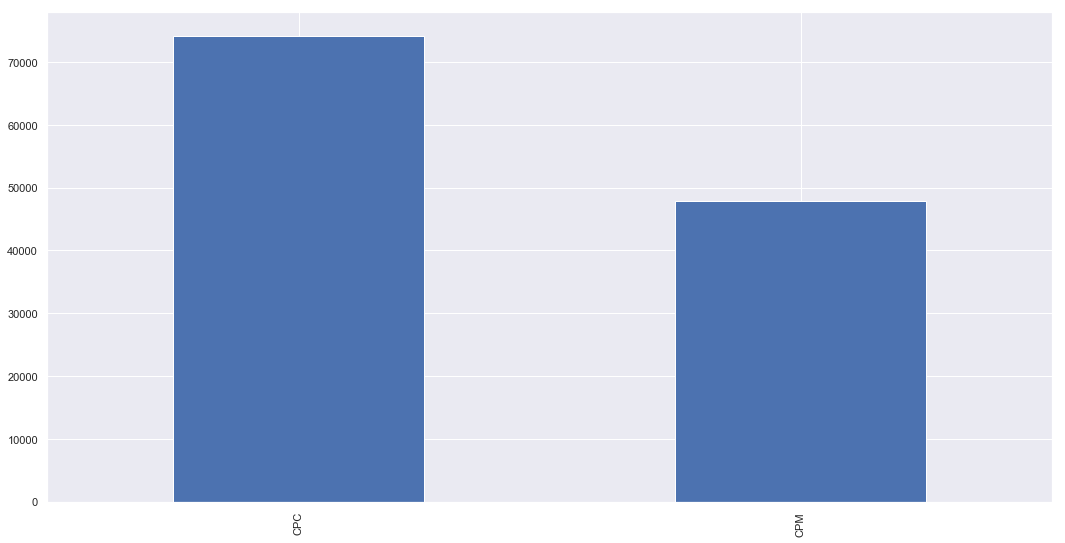

In [18]:
df.ad_cost_type.value_counts().plot(kind='bar')

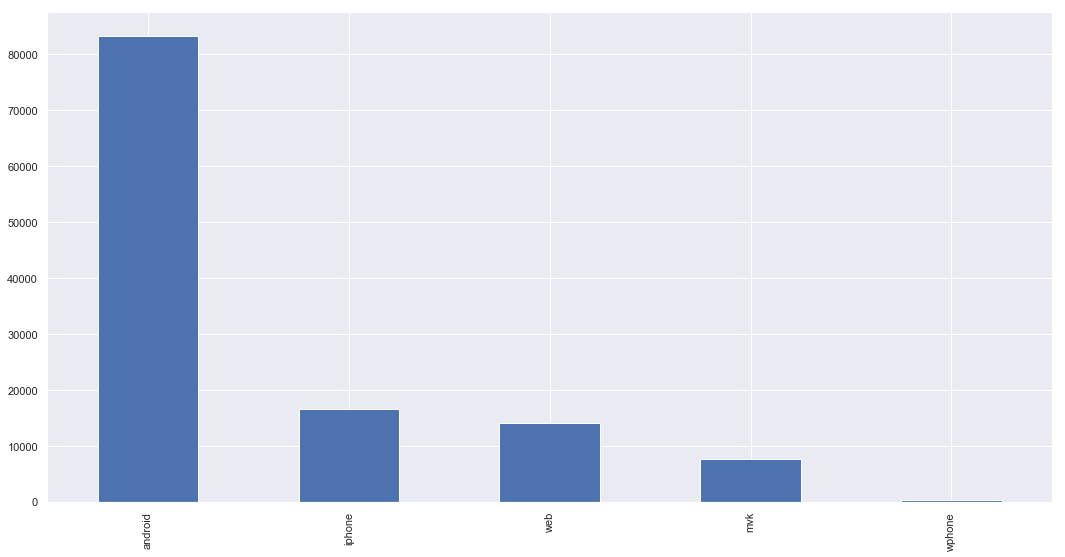

In [19]:
df.platform.value_counts().plot(kind='bar')

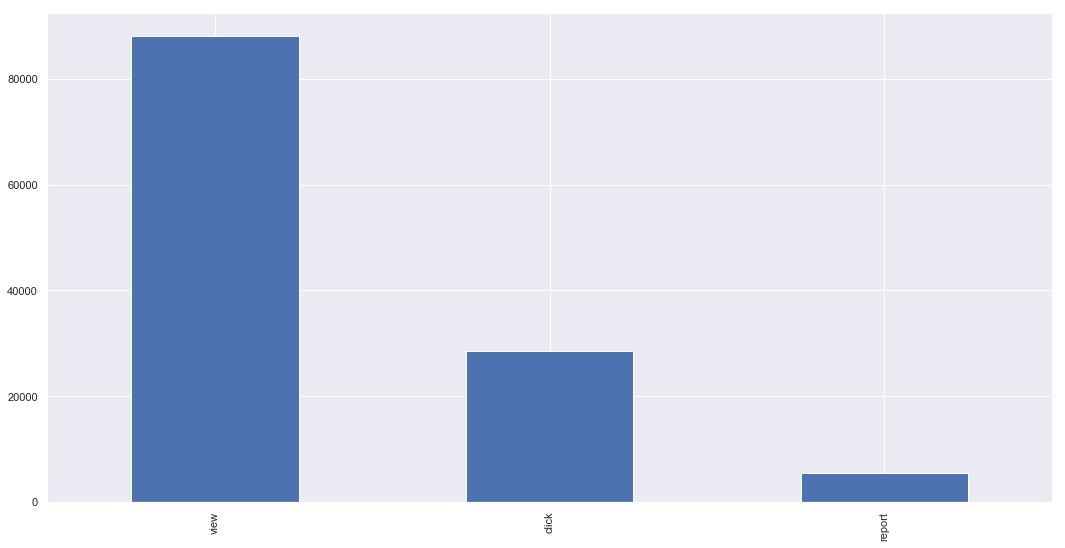

In [20]:
df.event.value_counts().plot(kind='bar')

Пока, из данных видно, что чаще всего происходили события типа view, основной платформой является android, основной тип трат за объявления - за клик. 

Также явно выделяется одна рекламная компания с наибольшим количеством действий по нескольким ad_id.

Посмотрим на данные поближе, а именно как распределяются по дням количество событий, по платформам, по типу трат:

In [22]:
adcost_data = df.pivot_table(index='date',
                                   columns='ad_cost_type',
                                   values='event',
                                   aggfunc='count')

events_data = df.pivot_table(index='date',
                                   columns='event',
                                   values='platform',
                                   aggfunc='count').reset_index()

count_by_platform = df.pivot_table(index='date',
                                   columns='platform',
                                   values='event',
                                   aggfunc='count').reset_index()

'''
.agg({'platform' : 'count',
     'event' : ['min', 'max', 'mean', 'count']     
     })
'''

events_data = events_data.merge(adcost_data, how = 'outer',on='date')

events_data = events_data.merge(count_by_platform, how = 'outer',on='date')

events_data

,date,click,report,view,CPC,CPM,android,iphone,mvk,web,wphone
0,2019-04-01,1827,362,2983,1866,3306,3411,750,255,733,23
1,2019-04-02,1898,366,3005,1786,3483,3446,807,275,717,24
2,2019-04-03,1837,304,3216,2005,3352,3482,875,251,736,13
3,2019-04-04,1871,368,2869,1975,3133,3343,813,235,695,22
4,2019-04-05,2188,432,2685,1947,3358,3491,827,309,656,22
5,2019-04-06,1577,300,2078,1492,2463,2656,612,202,471,14
6,2019-04-07,1510,297,2284,1567,2524,2712,638,229,493,19
7,2019-04-08,1545,311,7046,6134,2768,5530,1662,644,1049,17
8,2019-04-09,1784,351,5828,5002,2961,5105,1284,560,993,21
9,2019-04-10,1909,347,4842,4014,3084,4556,1141,466,905,30


Text(0, 0.5, 'Count')

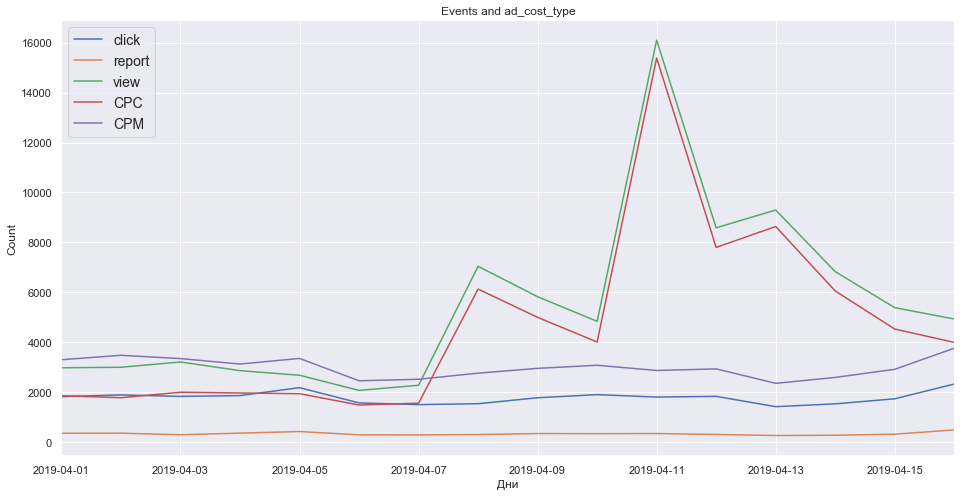

In [43]:
ax = events_data.drop(['android','iphone','mvk','web','wphone'], axis = 1)\
.plot(x = 'date', kind = 'line', figsize = (16,8))

ax.legend(loc=2, prop={'size': 14})
ax.set_title('Events and ad_cost_type')
ax.set_xlabel('Дни')
ax.set_ylabel('Count')

Как видно из таблицы, 11 апреля, количество событий view резко выросло.
Распределение роста по самым популярным платформам составило примерно 2-3 раза.

При этом вместе с ростом количества событий view также выросло значение CPC, понятно, что эти величины взаимосвязаны, но, так, чтобы рост был почти 1 в 1, выглядит несколько странно.

Поэтому посмотрим распределение CPC/CPM к количеству типов событий по дням.

In [33]:
groupped_by_events = df.groupby(['date', 'ad_cost_type', 'event'], as_index=False)\
.agg({'time' : 'count'})\
.rename(columns = {'time' : 'count'})

# request = groupped_by_events.event != 'report'
# groupped_by_events.query(expr='@request', inplace=True)

groupped_by_events["date"] = groupped_by_events["date"].astype("datetime64")

groupped_by_events.head(4)

,date,ad_cost_type,event,count
0,2019-04-01,CPC,click,117
1,2019-04-01,CPC,report,17
2,2019-04-01,CPC,view,1732
3,2019-04-01,CPM,click,1710


Text(0, 0.5, 'Count')

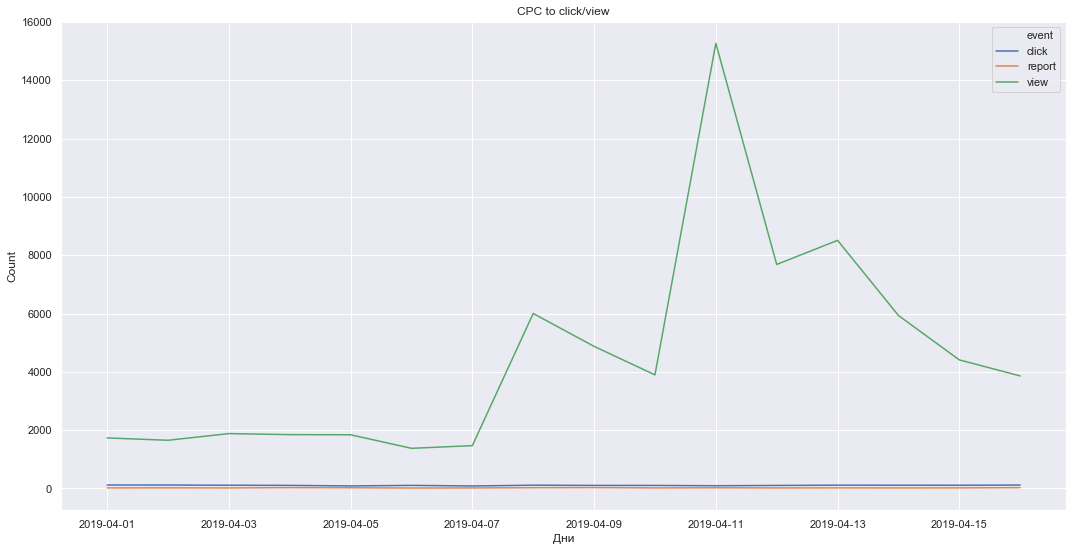

In [34]:
ax = sns.lineplot(x = 'date', y = 'count', hue = 'event', \
             data = groupped_by_events[groupped_by_events.ad_cost_type == 'CPC'].drop('ad_cost_type',axis = 1))

ax.set_title('CPC to click/view')
ax.set_xlabel('Дни')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

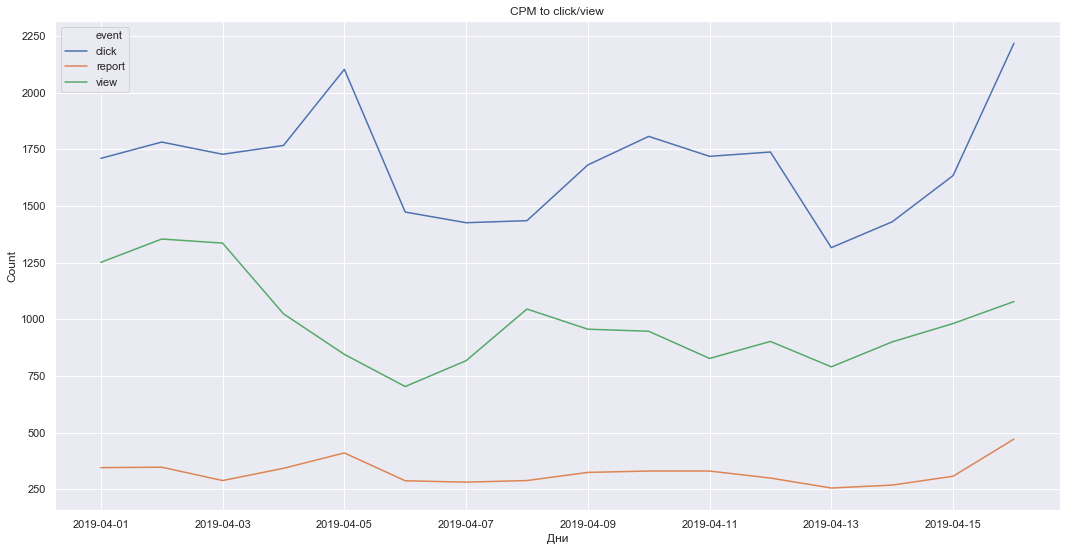

In [35]:
ax = sns.lineplot(x = 'date', y = 'count', hue = 'event', \
                  data = groupped_by_events[groupped_by_events.ad_cost_type == 'CPM'].drop('ad_cost_type',axis = 1))
ax.set_title('CPM to click/view')
ax.set_xlabel('Дни')
ax.set_ylabel('Count')

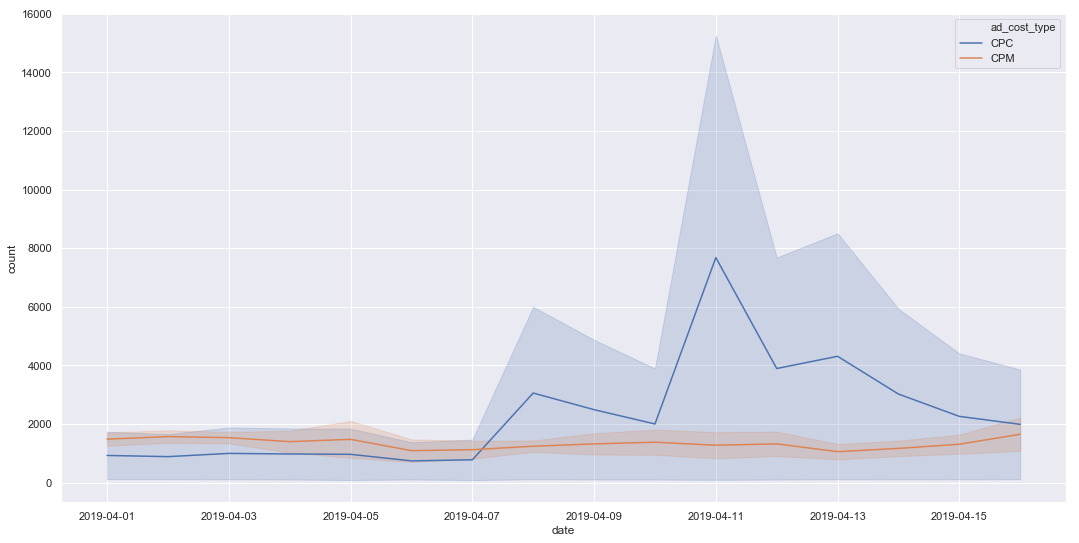

In [30]:
sns.lineplot(x = 'date', y = 'count',hue = 'ad_cost_type' ,data = groupped_by_events)

Вывод: наибольший вклад дают события типа CPC - view (хотя странно, что кликов при этом относительно мало).


Либо же, события CPC/CPM и click/view поменяны местами (в т.ч. и для агенства_2).

График для CPM больше похож на распределение кликов и просмотров (где вместо кликов - просмотры), тогда как CPC в точности наоборот.

Попробуем это проверить:

In [46]:
# to do
df[df.ad_id == 'ad_49554']['ad_cost_type'].unique()

array(['CPC'], dtype=object)

In [47]:
df[(df.date == '2019-04-05') & (df.event == 'view')][['event', 'ad_cost_type']].head()

,event,ad_cost_type
7,view,CPM
33,view,CPM
77,view,CPC
110,view,CPC
119,view,CPC


In [48]:
df[(df.date == '2019-04-11') & (df.event == 'view')][['event', 'ad_cost_type']].head()

,event,ad_cost_type
16,view,CPC
19,view,CPC
22,view,CPC
25,view,CPC
43,view,CPC


Не подвердилось.

Возможно есть какой-либо сбой по рекламному объявлению, имеющему наиболее количество событий?

Например смена агенства, рекламной кампании или же клиент как-либо изменился?

In [376]:
# пересечение по no_agency - есть agency
df[df.ad_id == 'ad_49554'].head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,time_from_timestamp
11,1555169778,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-13,2019-04-13 15:36:18
14,1555251921,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-14,2019-04-14 14:25:21
19,1555011001,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 19:30:01
20,1555061106,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-12,2019-04-12 09:25:06
22,1554977283,view,CPC,False,agency_2,client_47270,campaign_49554,ad_49554,android,2019-04-11,2019-04-11 10:08:03


In [112]:
for column in df[df.client_union_id == 'client_47270'].drop(['time', 'time_from_timestamp'], axis = 1): 
    print(df[df.client_union_id == 'client_47270'][column].unique())

['view' 'click' 'report']
['CPC']
[False]
['agency_2']
['client_47270']
['campaign_49554']
['ad_49564' 'ad_49554' 'ad_49556' 'ad_49560' 'ad_50872']
['web' 'android' 'mvk' 'iphone']
['2019-04-08' '2019-04-13' '2019-04-14' '2019-04-11' '2019-04-12'
 '2019-04-16' '2019-04-09' '2019-04-15' '2019-04-10' '2019-04-05']


In [114]:
for column in df[df.campaign_union_id == 'campaign_49554'].drop(['time', 'time_from_timestamp'], axis = 1): 
    print(df[df.campaign_union_id == 'campaign_49554'][column].value_counts()[:3])

view      47688
click        45
report        6
Name: event, dtype: int64
CPC    47739
Name: ad_cost_type, dtype: int64
False    47739
Name: has_video, dtype: int64
agency_2    47739
Name: agency_union_id, dtype: int64
client_47270    47739
Name: client_union_id, dtype: int64
campaign_49554    47739
Name: campaign_union_id, dtype: int64
ad_49554    27500
ad_49556     8218
ad_49560     7496
Name: ad_id, dtype: int64
android    34685
iphone      4971
web         4159
Name: platform, dtype: int64
2019-04-11    13941
2019-04-13     7593
2019-04-12     6698
Name: date, dtype: int64


In [103]:
for column in df[df.ad_id == 'ad_49554'].drop(['time', 'time_from_timestamp'], axis = 1): 
    print(df[df.ad_id == 'ad_49554'][column].unique())

['view' 'report' 'click']
['CPC']
[False]
['agency_2']
['client_47270']
['campaign_49554']
['ad_49554']
['android' 'mvk' 'web' 'iphone']
['2019-04-13' '2019-04-14' '2019-04-11' '2019-04-12' '2019-04-16'
 '2019-04-15' '2019-04-10']


In [104]:
for column in df[df.ad_id == 'ad_49554'].drop(['time', 'time_from_timestamp'], axis = 1): 
    print(df[df.ad_id == 'ad_49554'][column].value_counts())

view      27464
click        31
report        5
Name: event, dtype: int64
CPC    27500
Name: ad_cost_type, dtype: int64
False    27500
Name: has_video, dtype: int64
agency_2    27500
Name: agency_union_id, dtype: int64
client_47270    27500
Name: client_union_id, dtype: int64
campaign_49554    27500
Name: campaign_union_id, dtype: int64
ad_49554    27500
Name: ad_id, dtype: int64
android    21042
iphone      2197
mvk         2154
web         2107
Name: platform, dtype: int64
2019-04-11    9640
2019-04-13    6275
2019-04-12    4868
2019-04-14    3693
2019-04-15    2364
2019-04-16     388
2019-04-10     272
Name: date, dtype: int64


Что отдельно стоит отметить, это рекламное объявление проходит по типу трат - CPC и при этом состоит почти полностью из просмотров.

In [68]:
df_uni = df.groupby('ad_id', as_index=False).\
agg({'campaign_union_id' : 'unique',
     'agency_union_id' : 'unique',
     'client_union_id' : 'unique',
    'event' : 'count'})

In [69]:
df_uni.sort_values('event', ascending=False).head(15)

,ad_id,campaign_union_id,agency_union_id,client_union_id,event
17441,ad_49554,[campaign_49554],[agency_2],[client_47270],27500
17442,ad_49556,[campaign_49554],[agency_2],[client_47270],8218
17443,ad_49560,[campaign_49554],[agency_2],[client_47270],7496
17444,ad_49564,[campaign_49554],[agency_2],[client_47270],4491
17414,ad_47269,[campaign_47269],[agency_2],[client_47269],1867
18046,ad_99643,[campaign_99643],[agency_33],[client_99583],577
17545,ad_7701,[campaign_7701],[no_agency],[client_48],559
7324,ad_21831,[campaign_21831],[no_agency],[client_3313],491
11782,ad_387,[campaign_387],[no_agency],[client_6],461
3917,ad_1181,[campaign_1181],[no_agency],[client_7],441


Явно, здесь не видно того, чтобы целостность данных нарушалась, к тому же, данные тоже не расходятся с предыдущими выводами.

#### advertisments and agencies

Также еще не рассматривали рекламные агенства и объявления, в контексте их времени жизни.

Поэтому попробуем посмотреть какие рекламные объявления и в какие дни проигрывались, от какого-либо рекламного агента.

Попробуем построить графики, начала и конца рк, возможно здесь появится ясность.

Чтобы не рассматривать множество мелких групп рассмотрим клиентов без агенств и агенство 2, как имеющее наибольшее количество событий.

In [70]:
# построим графики по другим агенствам/клиентам
df_no_agency = df[df.agency_union_id == 'no_agency'].groupby(['date','ad_id'], as_index=False).\
agg({'event' : 'count'})

df_no_agency['date'] = pd.to_datetime(df_no_agency.date, format='%Y-%m-%d')

df_no_agency.sort_values(by = 'date', ascending=True, inplace=True)

In [71]:
#### drop ad_id, that are less than n in total
# use quantile maybe?
df_no_agency.quantile(.97)

event    8.0
Name: 0.97, dtype: float64

In [72]:
df_no_agency = df_no_agency[df_no_agency.event > 50]

In [73]:
df_no_agency.shape

(27, 3)

In [74]:
df_no_agency.head()

,date,ad_id,event
1435,2019-04-01,ad_7701,197
1403,2019-04-01,ad_5131,53
604,2019-04-01,ad_3024,53
2983,2019-04-02,ad_7701,114
2946,2019-04-02,ad_5132,52


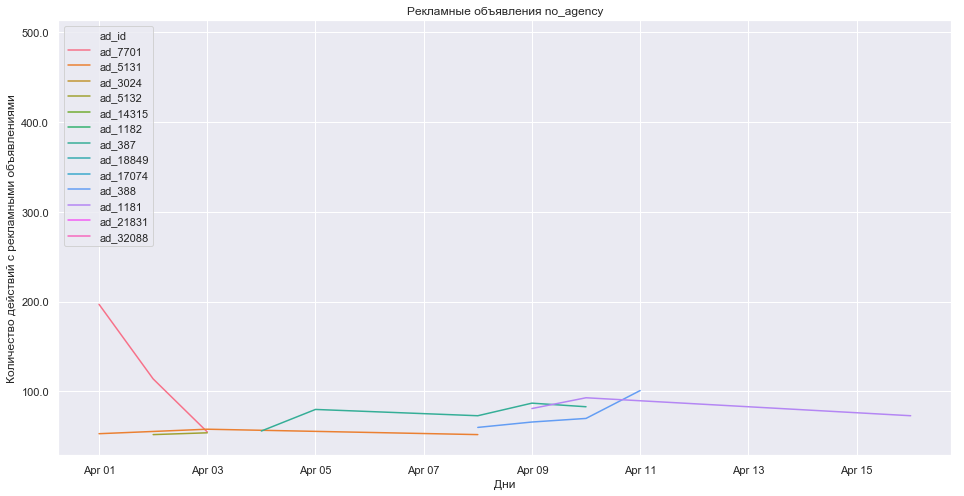

In [75]:
ax = sns.lineplot(x = 'date', y = 'event', hue = 'ad_id', data = df_no_agency)
ax.figure.set_size_inches(16, 8)
ax.set_title('Рекламные объявления no_agency')
ax.set_xlabel('Дни')
ax.set_ylabel('Количество действий с рекламными объявлениями')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

yfmt = tkr.FuncFormatter(y_fmt) 
ax.yaxis.set_major_formatter(yfmt)

И аналогично для агенства 2.

In [76]:
df_agency_2 = df[df.agency_union_id == 'agency_2'].groupby(['date','ad_id'], as_index=False).\
agg({'event' : 'count'})

df_agency_2['date'] = pd.to_datetime(df_agency_2.date, format='%Y-%m-%d')

df_agency_2.sort_values(by = 'date', ascending=True, inplace=True)

In [77]:
df_agency_2.quantile(.70)

event    145.2
Name: 0.7, dtype: float64

In [78]:
#### drop ad_id, that are less than n in total
# use quantile maybe?
df_agency_2 = df_agency_2[df_agency_2.event > 150]

In [106]:
df_agency_2.head()

,date,ad_id,event
40,2019-04-08,ad_49564,1438
37,2019-04-08,ad_47269,151
39,2019-04-08,ad_49560,2940
46,2019-04-09,ad_49560,1867
47,2019-04-09,ad_49564,1012


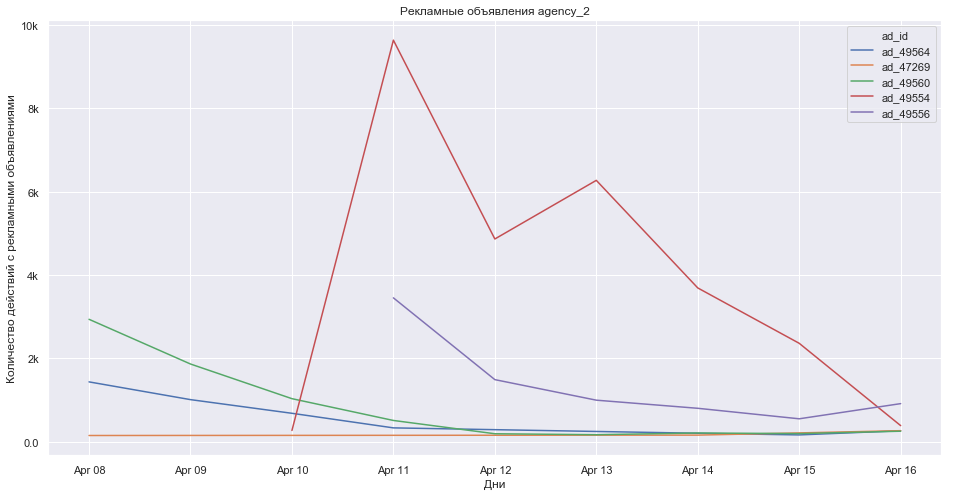

In [80]:
ax = sns.lineplot(x = 'date', y = 'event', hue = 'ad_id', data = df_agency_2)
ax.figure.set_size_inches(16, 8)
ax.set_title('Рекламные объявления agency_2')
ax.set_xlabel('Дни')
ax.set_ylabel('Количество действий с рекламными объявлениями')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

yfmt = tkr.FuncFormatter(y_fmt) 
ax.yaxis.set_major_formatter(yfmt)

Здесь можно сделать следующие выводы:
- гипотеза о том, что началась рекламная компания, которую посмотрело аномально большое количество пользователей, подтверждается. при этом наибольший эффект дают два объявления.
Одно из которых началось за день до второго.

- при этом, аномально мало кликов на объявления.

Дополнительно попробуем рассчитать параметр CTR для выбранных РК за весь период.

In [81]:
df_ctr = df[(df.campaign_union_id == 'campaign_1') & (df.ad_cost_type == 'CPC')]
df_ctr = df_ctr.groupby(['date','event'], as_index = False).count()
df_ctr['has_clicks'] = pd.Series(df_ctr.event == 'click').astype(int)
df_ctr['ctr'] = df_ctr.time / df_ctr.has_clicks

df_ctr.head(7)

,date,event,time,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp,has_clicks,ctr
0,2019-04-01,view,6,6,6,6,6,6,6,6,6,0,inf
1,2019-04-02,view,21,21,21,21,21,21,21,21,21,0,inf
2,2019-04-03,view,6,6,6,6,6,6,6,6,6,0,inf
3,2019-04-04,view,5,5,5,5,5,5,5,5,5,0,inf
4,2019-04-05,view,8,8,8,8,8,8,8,8,8,0,inf
5,2019-04-06,view,8,8,8,8,8,8,8,8,8,0,inf
6,2019-04-07,view,3,3,3,3,3,3,3,3,3,0,inf


In [122]:
#### ПОСЧИТАТЬ CTR, возможно больше value влили на рекламу

df_ctr = df[df.ad_cost_type == 'CPC'] #df[df.ad_id == 'ad_49554']

df_ctr = df_ctr.groupby(['campaign_union_id','event'], as_index=False).\
agg({'time' : 'count'   
    })

df_ctr.sort_values(['campaign_union_id'], inplace=True)

In [123]:
df_ctr = df_ctr.pivot_table(index='campaign_union_id',
               columns='event',
               #values='campaign_union_id',
               aggfunc='sum').reset_index()

In [124]:
df_ctr.columns = df_ctr.columns.droplevel()
df_ctr.columns = ['campaign_union_id', 'click', 'report', 'view']

In [125]:
#df_ctr[df_ctr.view > 1]

In [126]:
df_ctr['ctr'] = df_ctr.click / df_ctr.view

In [127]:
df_ctr.describe()

,click,report,view,ctr
count,918.000000,234.00000,1109.000000,52.000000
mean,1.821351,1.32906,65.120830,0.172237
std,3.876319,1.26298,1433.937362,0.321167
min,1.000000,1.00000,1.000000,0.000536
25%,1.000000,1.00000,2.000000,0.007288
50%,1.000000,1.00000,4.000000,0.020842
75%,1.000000,1.00000,14.000000,0.125000
max,63.000000,11.00000,47688.000000,1.000000


In [128]:
df_ctr[(df_ctr.click > 1) & (df_ctr.view > 0)].sort_values('ctr', ascending=False)

,campaign_union_id,click,report,view,ctr
1045,campaign_1889,2.0,1.0,19.0,0.105263
1960,campaign_7314,2.0,1.0,26.0,0.076923
2044,campaign_99142,3.0,NaN,59.0,0.050847
1959,campaign_5822,6.0,NaN,1006.0,0.005964
1963,campaign_7701,2.0,NaN,566.0,0.003534
1957,campaign_49554,45.0,6.0,47688.0,0.000944


Выводы.

Похоже, рекламных кампаний (по тратам CPC), которые имели бы и просмотры и клики не так уж и много.

#### 11 апреля.

Отдельно также рассмотрим день с пиковым количеством событий, а также попробуем понять, как можно детектировать такие аномальные всплески. 

In [150]:
df_splash_day = df[df.date == '2019-04-11']
print (df_splash_day.shape)

(18259, 11)


In [151]:
df_splash_day = df_splash_day.sort_values(by = 'time_from_timestamp')

# дропнем признаки наличие видео и дату как ненужные, видео т.к. оно редко встречается
df_splash_day.drop(['has_video','date'], axis = 1, inplace = True)
df_splash_day.reset_index(inplace=True,drop=True)

In [152]:
df_splash_day.head()

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp
0,1554940810,view,CPC,agency_33,client_99583,campaign_99643,ad_99643,web,2019-04-11 00:00:10
1,1554940815,view,CPM,agency_158,client_106198,campaign_106664,ad_106668,android,2019-04-11 00:00:15
2,1554940818,click,CPC,agency_54647,client_120417,campaign_120517,ad_120534,android,2019-04-11 00:00:18
3,1554940840,view,CPC,no_agency,client_26,campaign_4096,ad_4096,android,2019-04-11 00:00:40
4,1554940847,view,CPC,no_agency,client_2328,campaign_20614,ad_20615,android,2019-04-11 00:00:47


In [153]:
for column in df_splash_day.drop(['time', 'time_from_timestamp'], axis = 1): 
    print(df_splash_day[column].value_counts()[:5])

view      16097
click      1811
report      351
Name: event, dtype: int64
CPC    15383
CPM     2876
Name: ad_cost_type, dtype: int64
agency_2      14035
no_agency      2691
agency_158      105
agency_29        90
agency_33        81
Name: agency_union_id, dtype: int64
client_47270    13941
client_6          143
client_47269       92
client_99239       85
client_42          77
Name: client_union_id, dtype: int64
campaign_49554    13941
campaign_387        143
campaign_47269       79
campaign_99242       73
campaign_5822        62
Name: campaign_union_id, dtype: int64
ad_49554    9640
ad_49556    3455
ad_49560     512
ad_49564     334
ad_388       101
Name: ad_id, dtype: int64
android    12945
iphone      2141
web         1885
mvk         1271
wphone        17
Name: platform, dtype: int64


In [154]:
df_splash_day[df_splash_day.agency_union_id == 'agency_2'].groupby(['ad_cost_type','platform'], as_index=False).\
agg({'event' : 'count'})

,ad_cost_type,platform,event
0,CPC,android,10160
1,CPC,iphone,1501
2,CPC,mvk,1064
3,CPC,web,1308
4,CPM,android,2


Наибольшее количество событий за этот день составляют вида CPC- view, с agency_2, client_47270, campaign_49554, ad_49554 и ad_49556.

Построим таймлайн с распределением событий в течение дня.

In [155]:
df_splash_hour_index = df_splash_day.set_index(df_splash_day.time_from_timestamp.dt.hour)
df_splash_hour_index.head()

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp
time_from_timestamp,,,,,,,,,
0,1554940810,view,CPC,agency_33,client_99583,campaign_99643,ad_99643,web,2019-04-11 00:00:10
0,1554940815,view,CPM,agency_158,client_106198,campaign_106664,ad_106668,android,2019-04-11 00:00:15
0,1554940818,click,CPC,agency_54647,client_120417,campaign_120517,ad_120534,android,2019-04-11 00:00:18
0,1554940840,view,CPC,no_agency,client_26,campaign_4096,ad_4096,android,2019-04-11 00:00:40
0,1554940847,view,CPC,no_agency,client_2328,campaign_20614,ad_20615,android,2019-04-11 00:00:47


Сгруппируем и посмотрим в виде таймлайна на события.

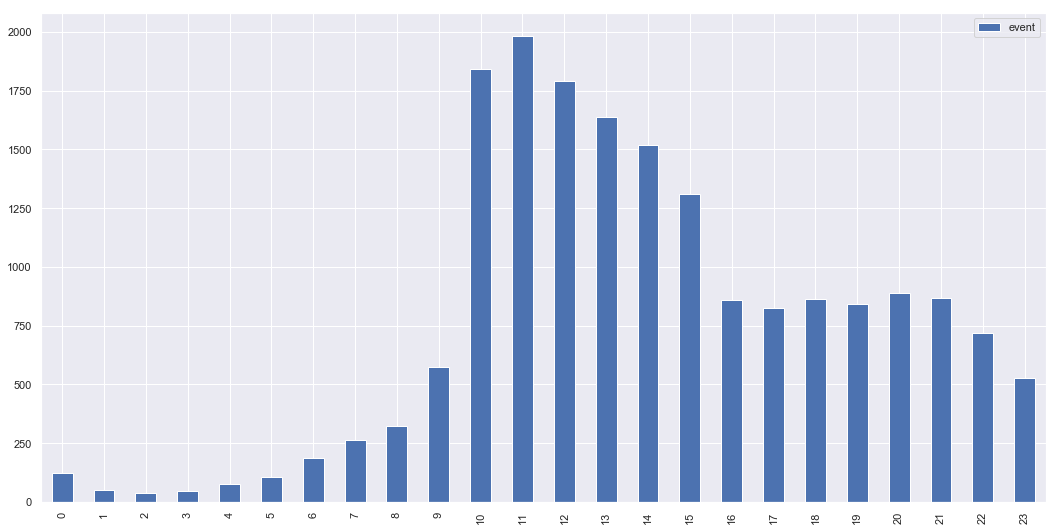

In [156]:
df_splash_hour_index.groupby(df_splash_hour_index.index, as_index=False)\
.agg({'event' : 'count'}).plot(kind = 'bar')

Самыми активными были часы 10:15.

Попробуем выделить паттерны/дубликаты.

Для того, чтобы лучше понять скорость роста, расчитаем разницу между событиями и посчитаем среднее между несколькими событиями используя скользящее окно.

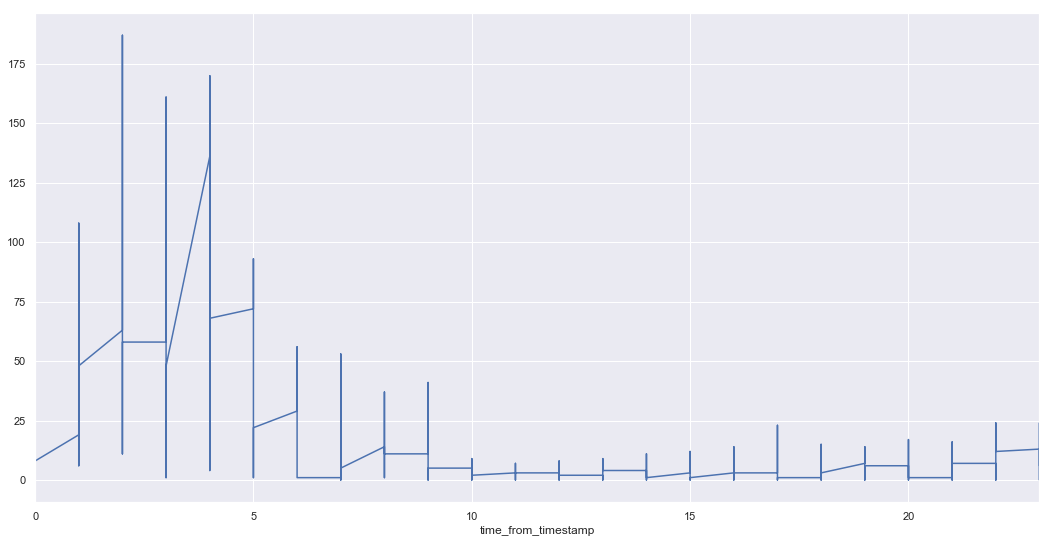

In [183]:
# rolling in pandas?
df_splash_hour_index['diff'] = df_splash_hour_index.time_from_timestamp.diff(periods = 1)
df_splash_hour_index['diff'] = df_splash_hour_index['diff'].astype('timedelta64[s]')

df_splash_hour_index['diff'].rolling(3, min_periods = 1).median().plot(kind = 'line')

# try to use 
# df.ewm(alpha=.7).mean().head()
# or
# df.expanding(3).mean().head()

In [195]:
# по интервалу в 3 страндартных отклонений
# не помогло, т.к. разброс идет большой
window = 50
df_splash_hour_index['median']= df_splash_hour_index['diff'].rolling(window, 1).mean()
df_splash_hour_index['std'] = df_splash_hour_index['diff'].rolling(window, 1).std()

#filter setup
df_splash_hour_index[(df_splash_hour_index['diff'] <= df_splash_hour_index['median']+3*df_splash_hour_index['std'])\
                     & (df_splash_hour_index['diff'] >= df_splash_hour_index['median']-3*df_splash_hour_index['std'])].head()

,time,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp,diff,median,std
time_from_timestamp,,,,,,,,,,,,
0,1554940818,click,CPC,agency_54647,client_120417,campaign_120517,ad_120534,android,2019-04-11 00:00:18,3.0,4.000000,1.414214
0,1554940840,view,CPC,no_agency,client_26,campaign_4096,ad_4096,android,2019-04-11 00:00:40,22.0,10.000000,10.440307
0,1554940847,view,CPC,no_agency,client_2328,campaign_20614,ad_20615,android,2019-04-11 00:00:47,7.0,9.250000,8.655441
0,1554940853,view,CPC,agency_2,client_47269,campaign_47269,ad_47269,iphone,2019-04-11 00:00:53,6.0,8.600000,7.635444
0,1554940856,click,CPM,agency_158,client_106937,campaign_107611,ad_107611,android,2019-04-11 00:00:56,3.0,7.666667,7.201852


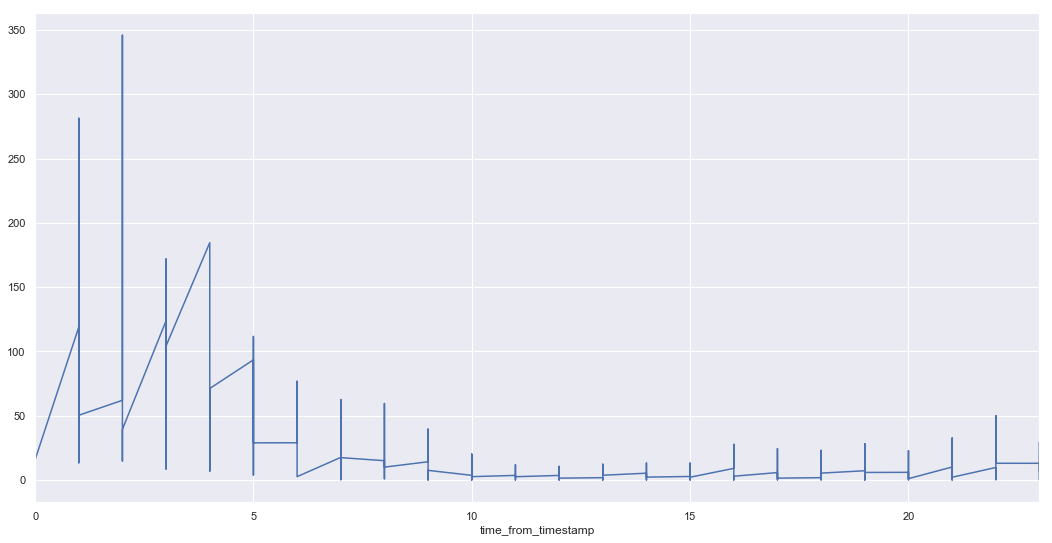

In [172]:
df_splash_hour_index['diff'].ewm(alpha=.7, min_periods = 1).mean().plot(kind = 'line')

Из особенностей видно, что наблюдается явный перерыв между часами, что может послужить сигналом к тому, что объявление искусственно прокручивается.

#### splash detection.

Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики. 

Иными словами, предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день. 

Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике?

Предложите вариант кода, который решает эту задачу. 

Реализовывать логику нотификации не нужно, только поиск аномального дня, часа, пятиминутки в данных рекламной статистики.

In [ ]:
# how to detect splash
# using rolling/ems - не катит, т.к. может быть просто большой трафик
# using arima - как вариант
# using linear regression? - как вариант
# LSTM for Regression - хорошо бы
# analyse types of events - с этим будет еще лучше
# + rmse

In [ ]:
# т.е. делаем алгоритм, который предыдущий день перебирает по определенному интервалу времени
# т.е. обучаемся за весь день и предсказываем только по скользящему окну
# измеряем допустим MAE/RMSE и если метрика выбивается допустим за среднее от 3х предыдущих интеравалов - алярм.

In [364]:
#df_test = df[df.date == '2019-04-11']

df_test = df[df.date == '2019-04-09']
df_test = df_test.set_index(df_test.time)
df_test.drop(['date', 'has_video', 'time'], axis = 1, inplace = True)
df_test = df_test.sort_values('time')
df_test.head()

,event,ad_cost_type,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,time_from_timestamp
time,,,,,,,,
1554768000,click,CPM,no_agency,client_23355,campaign_38083,ad_38089,web,2019-04-09 00:00:00
1554768047,click,CPM,no_agency,client_34763,campaign_45069,ad_45069,android,2019-04-09 00:00:47
1554768050,click,CPM,agency_88877,client_121351,campaign_121353,ad_121353,android,2019-04-09 00:00:50
1554768064,view,CPC,agency_2,client_47270,campaign_49554,ad_49564,android,2019-04-09 00:01:04
1554768070,view,CPM,agency_123,client_104846,campaign_104916,ad_104917,iphone,2019-04-09 00:01:10


In [365]:
window_interval_sec = 300 # 10 min
start_time = df_test.index[0]#df_test.iloc[0]
end_time = df_test.index[-1] #df_test.iloc[df_test.shape[0]-1]
chunk_size = int((24 * 60 * 60) / window_interval_sec)
print (chunk_size) # equals amount of 5 minutes
# хорошо бы доработать до использования четких каждые 5 мин, а не по кол-ву, которое есть.

288


In [366]:
"""day_length = end_time - start_time
day_length / window_interval_sec""";

In [367]:
df_test['time_group'] = (df_test.assign(timestamp=df_test['time_from_timestamp'].dt.floor('5min'))
       .groupby(pd.Grouper(key='time_from_timestamp',freq='5min'))
       .ngroup())
day_groupped = df_test.groupby('time_group', as_index=False)\
.agg({'event' : 'count'})

In [368]:
day_groupped.shape

(288, 2)

In [369]:
day_groupped.head()

,time_group,event
0,0,24
1,1,17
2,2,19
3,3,15
4,4,11


288


In [375]:
day_groupped[day_groupped.time_group <= 12]

,time_group,event
0,0,24
1,1,17
2,2,19
3,3,15
4,4,11
5,5,15
6,6,13
7,7,6
8,8,4
9,9,6


In [377]:
from statsmodels.tsa.arima_model import ARIMA

In [372]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)

In [397]:
train = day_groupped[day_groupped.event < 100]['event']
test = day_groupped[day_groupped.event > 100]['event']

In [399]:
# учимся за час, предсказываем на 5 мин
print(chunk_size)
history = [train]
predictions = list()
#actuals=list()
for i in range(chunk_size):
    # history = day_groupped[day_groupped.time_group <= i+11]
    model = ARIMA(endog  = history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]    
    
    # actual = day_groupped[day_groupped.time_group == (i+12)]

    
    model.fit(history.event)
    
    predicts = stepwise_model.predict(actual.event)
    
    predictions.append(predicts)
    actuals.append(actual)

    
#error = math.sqrt(mean_squared_error(test_log, predict_log))
#print('Test rmse: %.3f' % error)

288


ValueError: Insufficient degrees of freedom to estimate

In [270]:
metric_list = []
for i in range(chunk_size):
    start = df_test.index[0] + i*window_interval_sec
    end = df_test.index[0] + (i+1)*window_interval_sec
    chunk = df_test[(df_test.index > start) & (df_test.index < end)]
    # predict chunk
    
    # calculate metric
    
    # get prev 3 metrics
    
    # compare
    
    # send signal

(40, 8)
(34, 8)
(26, 8)
(19, 8)
(10, 8)
(13, 8)
(12, 8)
(10, 8)
(8, 8)
(12, 8)
(10, 8)
(9, 8)
(12, 8)
(6, 8)
(9, 8)
(5, 8)
(9, 8)
(11, 8)
(8, 8)
(11, 8)
(7, 8)
(8, 8)
(12, 8)
(8, 8)
(9, 8)
(15, 8)
(16, 8)
(17, 8)
(24, 8)
(28, 8)
(17, 8)
(29, 8)
(24, 8)
(26, 8)
(32, 8)
(38, 8)
(42, 8)
(46, 8)
(47, 8)
(52, 8)
(39, 8)
(64, 8)
(60, 8)
(42, 8)
(71, 8)
(71, 8)
(71, 8)
(70, 8)
(82, 8)
(72, 8)
(64, 8)
(78, 8)
(61, 8)
(74, 8)
(72, 8)
(80, 8)
(71, 8)
(65, 8)
(82, 8)
(84, 8)
(78, 8)
(60, 8)
(64, 8)
(75, 8)
(63, 8)
(80, 8)
(75, 8)
(75, 8)
(62, 8)
(71, 8)
(65, 8)
(67, 8)
(82, 8)
(72, 8)
(54, 8)
(78, 8)
(56, 8)
(60, 8)
(87, 8)
(73, 8)
(56, 8)
(60, 8)
(72, 8)
(59, 8)
(84, 8)
(63, 8)
(81, 8)
(59, 8)
(76, 8)
(70, 8)
(53, 8)
(46, 8)
(54, 8)
(38, 8)
(42, 8)
(68, 8)
(74, 8)
(89, 8)
(69, 8)
(76, 8)
(63, 8)
(69, 8)
(65, 8)
(71, 8)
(74, 8)
(59, 8)
(74, 8)
(68, 8)
(61, 8)
(58, 8)
(58, 8)
(62, 8)
(65, 8)
(71, 8)
(83, 8)
(70, 8)
(94, 8)
(99, 8)
(79, 8)
(83, 8)
(87, 8)
(72, 8)
(70, 8)
(77, 8)
(60, 8)
(72, 8)
(75

In [240]:
# iterate over df
for k,g in df_test.groupby(np.arange(df_test.shape[0])//chunk_size):
    print(k, g)

0.0              event ad_cost_type agency_union_id client_union_id  \
time                                                              
1554768000   click          CPM       no_agency    client_23355   
1554768047   click          CPM       no_agency    client_34763   
1554768050   click          CPM    agency_88877   client_121351   
1554768064    view          CPC        agency_2    client_47270   
1554768070    view          CPM      agency_123   client_104846   
1554768077    view          CPC        agency_2    client_47269   
1554768116    view          CPC      agency_264   client_109618   
1554768117    view          CPC        agency_2    client_47270   
1554768131    view          CPC       agency_33    client_99583   
1554768139    view          CPC        agency_2    client_47270   
1554768140    view          CPC       no_agency      client_204   
1554768141    view          CPC        agency_2    client_47270   
1554768145    view          CPC        agency_2    client_

17.0              event ad_cost_type agency_union_id client_union_id  \
time                                                              
1554828506    view          CPM     agency_1782   client_117210   
1554828514    view          CPC        agency_2    client_47270   
1554828528   click          CPM       agency_77   client_104394   
1554828535   click          CPM       no_agency    client_22195   
1554828537    view          CPC        agency_2    client_47270   
1554828538   click          CPM       no_agency    client_47165   
1554828539    view          CPC       agency_33    client_99583   
1554828566    view          CPM      agency_123   client_105021   
1554828591    view          CPC       no_agency      client_219   
1554828616   click          CPM      agency_158   client_106761   
1554828637    view          CPC        agency_2    client_47270   
1554828639    view          CPM       no_agency      client_744   
1554828642  report          CPM       no_agency    client

Выводы.